In [1]:
using Revise
using DelimitedFiles, HDF5, FileIO
using Plots, Rsvg, LaTeXStrings
using Chemfiles, JUMD
using LinearAlgebra, Statistics
home = "/home/pbarletta/labo/18/lbp/run"
rtdos = "/home/pbarletta/labo/18/lbp/rtdos_log"
plotly()

Plots.PlotlyBackend()

In [2]:
using GeometryTypes, Makie

### Lee modos, volumen original y  volúmenes NDD. Obtiene VGV

In [4]:
pdb = "4xcp"
# Leo modos
modes_4xcp, evals_4xcp = JUMD.readPtrajModes(
    joinpath(home, pdb,  "pca", string("full_modes_", pdb)))

# AAs
aa3 = convert(Int64, length(evals_4xcp))
aa = convert(Int64, aa3 / 3)

# Leo volumen de la traj
trj_vol = convert(Array{Float64, 1}, 
    readdlm(joinpath(home, pdb, "cavidad", string("vol_trj_", pdb)))[:, 3]);

# Leo volúmenes originales
vol_avg_4xcp = convert(Float64, readdlm(joinpath(home, pdb,  "ndd", string("vol_avg_", pdb)))[3])

# Leo volúmenes NDD
ndd_out_4xcp = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb,  "ndd", string("out_ndd_", pdb)))[2:end, 2])

# VGV
vgv_4xcp = (ndd_out_4xcp .- vol_avg_4xcp) .* evals_4xcp
vgv_4xcp = vgv_4xcp ./ norm(vgv_4xcp);

## Volumen de la trayectoria

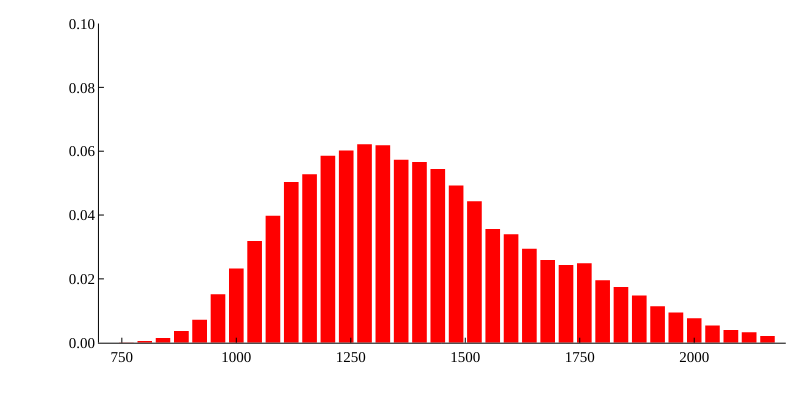

In [4]:
st = 40
bin_vol = collect(700:st:2200)
wgh_vol = fill(1.0, length(trj_vol))

# Histograma ponderado
Wbins_vol_4xcp, Whis_vol_4xcp = JUMD.WeightedHist(trj_vol, bin_vol, wgh_vol, true, false);

plt_his_vol = bar(Wbins_vol_4xcp, Whis_vol_4xcp,
    xlims = (700, 2200), ylims = (0, .1),
    xticks = 500:250:2000,
    grid = false, guidefont = font(16, "cursive"), tickfont = font(11, "cursive"),
    yaxis = L"Frequency $[cm^{-1}]$", xaxis = L"Volume $[\AA^3]$ ",
    linecolor = false, fillcolor = Colors.colorant"#FF0000",
    legend = false)

In [341]:
savefig(plt_his_vol, joinpath(rtdos, "papel", "1", string("1_vol_", pdb, ".svg")))

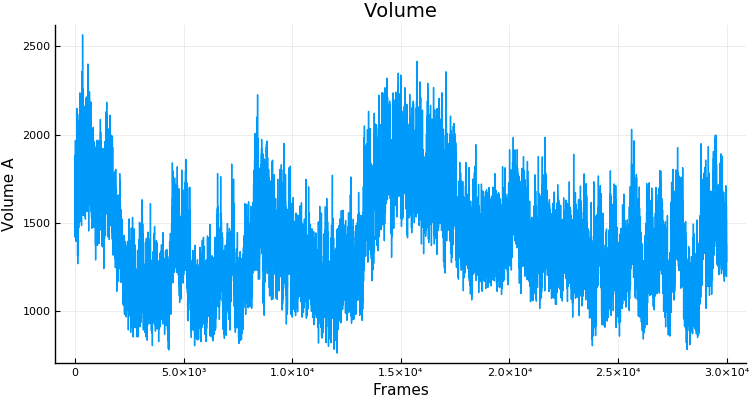

In [39]:
plot(trj_vol,
    yaxis = "Volume A", xaxis = "Frames", title = "Volume",
    xticks = collect(0:5000:5E4),
    legend = false, size = (750, 400))

In [40]:
[ mean(trj_vol) ; std(trj_vol) ]

2-element Array{Float64,1}:
 1396.8782924333334
  266.371461131622 

# Energía

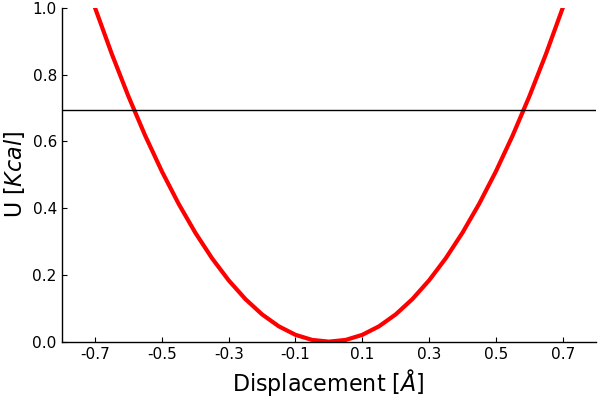

In [42]:
pasos = collect(-.8:.05:.8)
npasos = length(pasos)
RT = 0.693

E_4xcp = Array{Float64,1}(undef, npasos)
i = 0
for d in pasos
    i+=1
    E_4xcp[i] = JUMD.energiaGdte(evals_4xcp, vgv_4xcp, d)
end

plt_u = plot(pasos, E_4xcp,
    xticks = -.7:.2:.7, yticks = 0:.2:1.,   
    xlims = (-.8, .8), ylims = (0, 1.),
    grid = false, guidefont = font(16, "Helvetica"), tickfont = font(11, "Helvetica"),
    yaxis = L"U $[Kcal]$", xaxis = L"Displacement $[\AA]$ ",
    linecolor = Colors.colorant"#FF0000", linewidth = 3,
    legend = false)

hline!([RT], linecolor = Colors.colorant"black")

In [338]:
savefig(plt_u, joinpath(rtdos, "papel", "7", string("7_U_", pdb, ".svg")))

# PCA projección
#### Obtengo vectores diferencia de la trayectoria. Esto lo hago una sola vez

### Obtengo proyecciones de PCA sobre trayectoria

In [5]:
dif = h5read(joinpath(rtdos, string("diff_", pdb, ".h5")), "dif")
norm_dif = mapslices(x -> x ./ norm(x), dif,  dims = 1)
nframes = size(dif)[2]

prj_1_4xcp = Array{Float64, 1}(undef, nframes)
prj_2_4xcp = Array{Float64, 1}(undef, nframes)
prj_3_4xcp = Array{Float64, 1}(undef, nframes)

for i = 1:nframes
    prj_1_4xcp[i] = dot(norm_dif[:, i], modes_4xcp[:, 1])
    prj_2_4xcp[i] = dot(norm_dif[:, i], modes_4xcp[:, 2])
    prj_3_4xcp[i] = dot(norm_dif[:, i], modes_4xcp[:, 3])
end

# Smooth
smooth_prj_1_4xcp = [ mean(prj_1_4xcp[i:i+9]) for i = 1:10:length(prj_1_4xcp)-9 ]
smooth_prj_2_4xcp = [ mean(prj_2_4xcp[i:i+9]) for i = 1:10:length(prj_2_4xcp)-9 ]
smooth_prj_3_4xcp = [ mean(prj_3_4xcp[i:i+9]) for i = 1:10:length(prj_3_4xcp)-9 ];

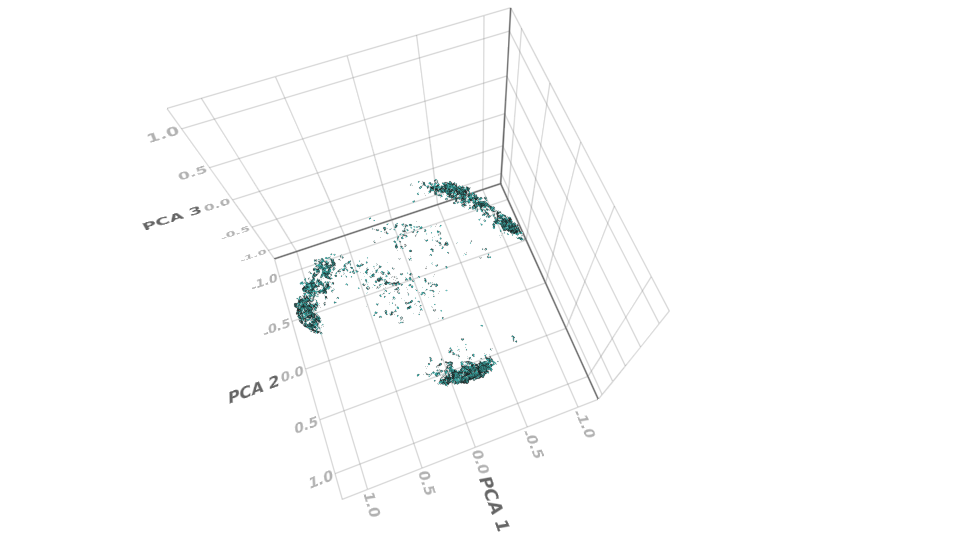

In [6]:
xyz_bins = collect(-1:.025:1)

his_ind, his = JUMD.HisInd3D(smooth_prj_1_4xcp, smooth_prj_2_4xcp, smooth_prj_3_4xcp,
    xyz_bins, xyz_bins, xyz_bins)

cuentas = 2
msk = his .> cuentas
main_his = his[msk]
main_his_ind = his_ind[msk];

sc = Makie.volume(convert(Array{Float64,3}, msk), algorithm = :iso)
sc[Axis][:names, :axisnames] = ("PCA 1", "PCA 2", "PCA 3")

tck_lab = string.(collect(-1.:.5:1.))
sc[Axis][:ticks][:labels] = (tck_lab, tck_lab, tck_lab)

eyepos = Vec3f0(50, 120, 230)
lookat = Vec3f0(10, 15, -35)
update_cam!(sc, eyepos, lookat)
sc

In [283]:
Makie.save(joinpath(rtdos, string("3D_", pdb, ".png")), sc)

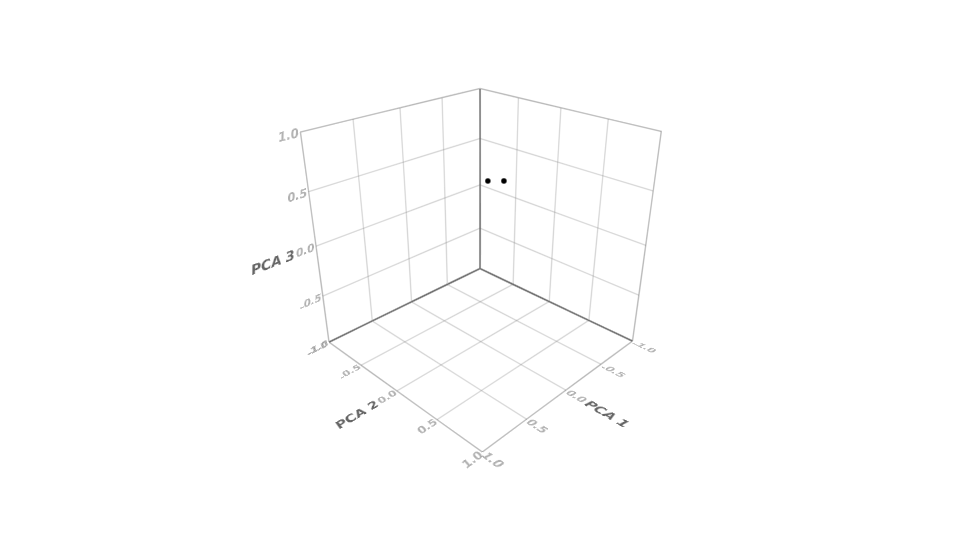

In [8]:
prj_123 = hcat(smooth_prj_1_4xcp, smooth_prj_2_4xcp, smooth_prj_3_4xcp)
ii = 1
jj = 10

sc_123 = Makie.scatter(smooth_prj_1_4xcp[1:2], smooth_prj_2_4xcp[1:2], smooth_prj_3_4xcp[1:2],
    limits = HyperRectangle(-1, -1, -1, 2, 2, 2),
    markersize = .05, markeralpha = .3, markerstrokewidth = .0, seriescolor = :blue,
    fillcolor = :blue, linecolor = :blue)
sc_123[Axis][:names, :axisnames] = ("PCA 1", "PCA 2", "PCA 3")

tck_lab = string.(collect(-1.:.5:1.))
sc_123[Axis][:ticks][:labels] = (tck_lab, tck_lab, tck_lab)

s = sc_123[end];
sc_123

In [17]:
methods(Point3f0)

# 8 methods for generic function "(::Type)":
[1] (::Type{Point{S,T}})(x::Point) where {S, T} in GeometryTypes at /home/pbarletta/.julia/packages/StaticArrays/Ze5H3/src/FixedSizeArrays.jl:139
[2] (::Type{Point{S,T}})(x::StaticArrays.StaticArray{Tuple{N},T,1} where T where N) where {S, T} in GeometryTypes at /home/pbarletta/.julia/packages/StaticArrays/Ze5H3/src/FixedSizeArrays.jl:137
[3] (::Type{SV})(x::StaticArrays.StaticArray{Tuple{N},T,1} where T where N) where SV<:Point in GeometryTypes at /home/pbarletta/.julia/packages/StaticArrays/Ze5H3/src/FixedSizeArrays.jl:151
[4] (::Type{Point{S,T1}})(x::AbstractArray{T2,1}) where {S, T1, T2} in GeometryTypes at /home/pbarletta/.julia/packages/StaticArrays/Ze5H3/src/FixedSizeArrays.jl:117
[5] (::Type{Point{S,T}})(x::Tuple{Vararg{T,S}}) where {S, T} in GeometryTypes at /home/pbarletta/.julia/packages/StaticArrays/Ze5H3/src/FixedSizeArrays.jl:95
[6] (::Type{Point{S,T}})(x::Tuple{Vararg{Any,S}}) where {S, T} in GeometryTypes at /home/pbarletta/.julia/packages/StaticArrays/Ze5H3/src/FixedSizeArrays.jl:99
[7] (::Type{Point{S,T}})(x) where {S, T} in GeometryTypes at /home/pbarletta/.julia/packages/StaticArrays/Ze5H3/src/FixedSizeArrays.jl:122
[8] (::Type{SA})(x...) where SA<:StaticArrays.StaticArray in StaticArrays at /home/pbarletta/.julia/packages/StaticArrays/Ze5H3/src/convert.jl:3

In [21]:
a = [ Point3f0(rand(3)) ; Point3f0(rand(3)) ]

6-element Point{6,Float32}:
 0.9239965 
 0.21408242
 0.03605465
 0.33250624
 0.85030895
 0.15478596

In [36]:
b = rand(Point3f0, 2)

2-element Array{Point{3,Float32},1}:
 [0.85137, 0.033231, 0.547547] 
 [0.712881, 0.582942, 0.143144]

2-element Array{Point{3,Float32},1}:
 [0.617784, 0.108975, 0.786992]
 [0.171014, 0.25573, 0.323106] 

2-element Array{Point{3,Float32},1}:
 [0.629447, 0.380531, 0.634158] 
 [0.795122, 0.105564, 0.0179831]

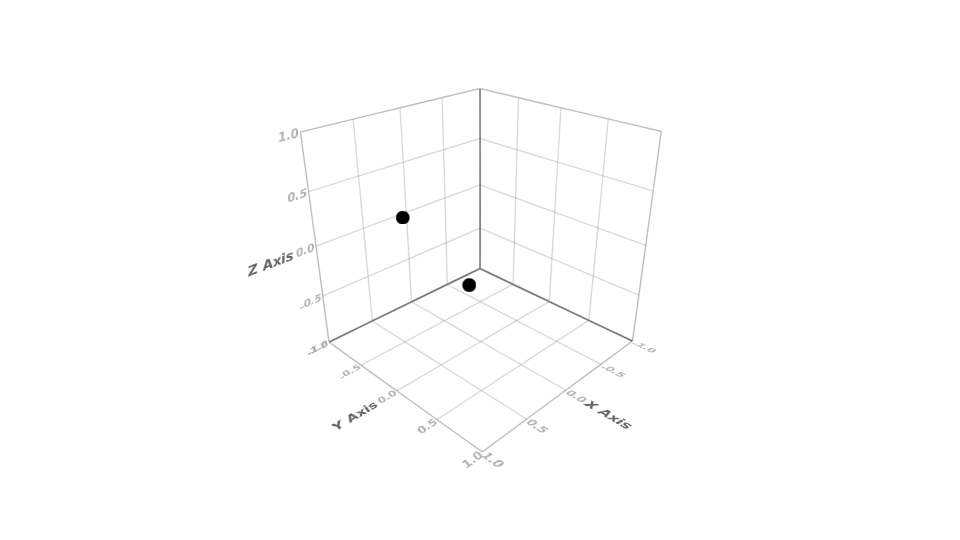

In [40]:
scn = Makie.scatter(b, limits = GeometryTypes.HyperRectangle(-1, -1, -1, 2, 2, 2))

In [41]:
s = scn[end];

In [46]:
s[1] = rand(Point3f0, (2))

2-element Array{Point{3,Float32},1}:
 [0.45802, 0.495291, 0.292768]  
 [0.0999144, 0.622918, 0.206042]

In [52]:
push!(s[1], rand(Point3f0, (2)))

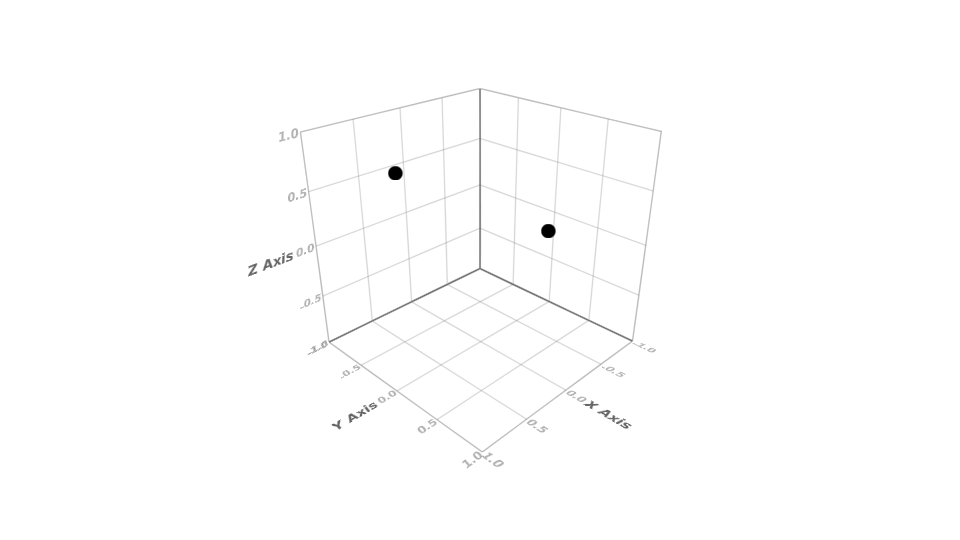

In [53]:
scn

In [9]:
as = [Point3f0(prj_123[1, :])]
for i in 2:length(smooth_prj_1_4xcp)
    push!(as, Point3f0(prj_123[i, :]))
end

In [ ]:
as

In [ ]:
s[1] = as[1:2]

In [16]:
as[1:2]

2-element Array{Point{3,Float32},1}:
 [-0.539556, -0.241318, 0.37641] 
 [-0.514698, -0.418963, 0.334738]

In [ ]:
record(sc_123, "as.mp4", range(jj, stop = length(smooth_prj_1_4xcp), step = 100)) do kk
    #push!(s[1], as[kk])
    #s = as[kk:kk+9]
    s[1] = Reactive.Signal(as[kk:kk+9])
    AbstractPlotting.force_update!()
    sleep(1/24)
end

In [49]:
Rectangle(1, 1, 1, 1)

3×3 Array{Float64,2}:
 0.201266  0.393117  0.75142 
 0.743839  0.282849  0.124486
 0.462905  0.657191  0.363957

In [16]:
typeof(as[1:10])

Array{Point{3,Float32},1}

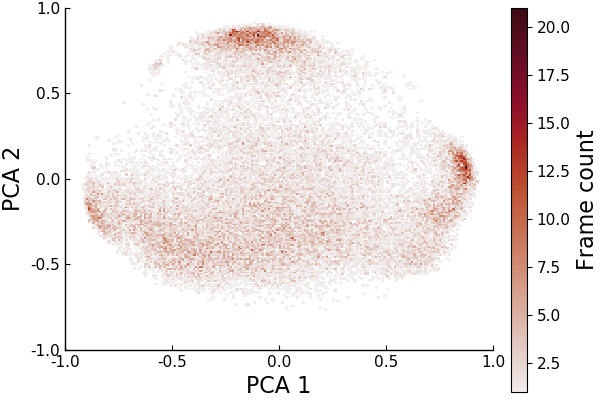

In [252]:
plt_2his = Plots.histogram2d(smooth_prj_1_4xcp, smooth_prj_2_4xcp,
    xlims = (-1., 1.), ylims = (-1., 1.),
    guidefont = font(16, "Helvetica"), tickfont = font(11, "Helvetica"),
    yaxis = "PCA 2", xaxis = "PCA 1",
    colorbar_title = "Frame count",
    nbins = 180, seriescolor = :amp, grid = false)

In [366]:
savefig(plt_2his, joinpath(rtdos, "papel", "2", string("2_PCAHis_", pdb, ".svg")))

## Métodos de Marcos

In [45]:
# Read Pnumbers
marcos_pnu = h5read(joinpath(rtdos, string("marcos_pnu_", pdb, ".h5")), "pnu")

# Read Frecuencia de apariciónd de c/ modo en los subespacios de pnumber modos
marcos_modos = Array{Array{Int64, 1}}(undef, nframes)
fid = h5open(joinpath(rtdos, string("marcos_modos_", pdb, ".h5")), "r")
for i = 1:nframesb
    marcos_modos[i] = read(fid, string("frame_", i))
end
close(fid)
flat_marcos_modos = collect(Iterators.flatten(marcos_modos));

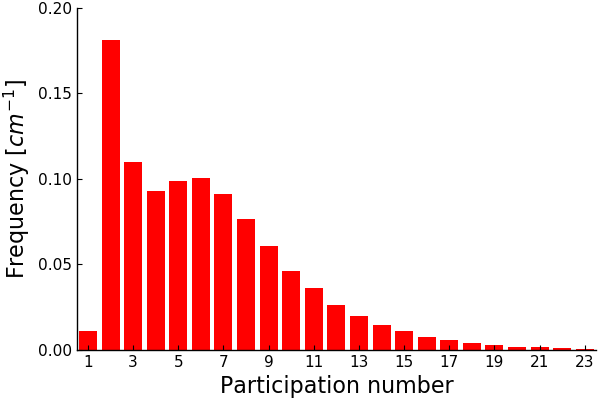

In [46]:
bin_pnu = collect(1:1:25)
wgh_pnu = fill(1.0, length(marcos_pnu))

# Histograma ponderado
bins_marcos_pnu, his_marcos_pnu = JUMD.WeightedHist(marcos_pnu, bin_pnu, wgh_pnu, true, false);

plt_his_pn = bar(bins_marcos_pnu .- .5, his_marcos_pnu,
    ylims = (0, .2), xlims = (.5, 23.5),
    xticks = 1:2:23, yticks = 0:.05:.2,
    guidefont = font(16, "Helvetica"), tickfont = font(11, "Helvetica"),
    fillcolor = Colors.colorant"#FF0000", linecolor = false,
    yaxis = L"Frequency $[cm^{-1}]$", xaxis = "Participation number",
    legend = false, grid = false)

In [360]:
savefig(plt_his_pn, joinpath(rtdos, "papel",  "2", string("2_HisPn_", pdb, ".svg")))

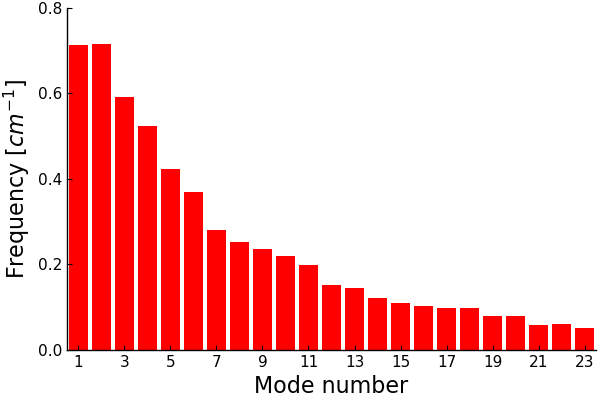

In [47]:
bin_mod = collect(1:1:25)
wgh_mod = fill(1 / nframes, length(flat_marcos_modos))

# Histograma ponderado
bins_marcos_mod, his_marcos_mod = JUMD.WeightedHist(flat_marcos_modos, bin_mod, wgh_mod, false, false);

plt_freq_pn = bar(bins_marcos_mod .- .5, his_marcos_mod,
    ylims = (0, .8), xlims = (.5, 23.5),
    xticks = 1:2:23, yticks = 0:.2:.8,
    guidefont = font(16, "Helvetica"), tickfont = font(11, "Helvetica"),
    fillcolor = Colors.colorant"#FF0000", linecolor = false,
    yaxis = L"Frequency $[cm^{-1}]$", xaxis = "Mode number",
    legend = false, grid = false,)

In [364]:
savefig(plt_freq_pn, joinpath(rtdos, "papel",  "2", string("2_ModPn_", pdb, ".svg")))